In [104]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f
import numpy as np

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns

In [106]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelBinarizer, OrdinalEncoder
from imblearn.over_sampling import BorderlineSMOTE

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [108]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score

In [109]:
from IPython.display import display, HTML

In [110]:
spark = SparkSession.builder.master('local').appName('BreastCancer').config('spark.executor.memory','6gb').getOrCreate()

In [111]:
url = 'C:/Users/Dylan/Desktop/Datasets/result-breast-cancer.csv'
df = spark.read.format('com.databricks.spark.csv').options(header='True', inferschema='True').load(url)
df.show(10)

+---+-----+---------+----------+---------+---------+---------+------+-----------+--------+--------------------+
| id|  age|menopause|tumor-size|inv-nodes|node-caps|deg-malig|breast|breast-quad|irradiat|               Class|
+---+-----+---------+----------+---------+---------+---------+------+-----------+--------+--------------------+
|  1|40-49|  premeno|     25-29|    24-26|      yes|        3| right|    central|      no|   recurrence-events|
|  2|40-49|  premeno|     25-29|      0-2|       no|        2|  left|   left_low|      no|no-recurrence-events|
|  3|60-69|     lt40|     25-29|      0-2|       no|        2| right|   left_low|      no|no-recurrence-events|
|  4|40-49|     ge40|     10-14|      0-2|       no|        3|  left|   left_low|      no|no-recurrence-events|
|  5|40-49|  premeno|       5-9|      0-2|       no|        1| right|    central|      no|no-recurrence-events|
|  6|50-59|     ge40|     20-24|      0-2|       no|        2| right|   left_low|      no|no-recurrence-

In [112]:
df = df.toPandas()
df.head()

,id,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,1,40-49,premeno,25-29,24-26,yes,3,right,central,no,recurrence-events
1,2,40-49,premeno,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
2,3,60-69,lt40,25-29,0-2,no,2,right,left_low,no,no-recurrence-events
3,4,40-49,ge40,10-14,0-2,no,3,left,left_low,no,no-recurrence-events
4,5,40-49,premeno,5-9,0-2,no,1,right,central,no,no-recurrence-events


In [113]:
df = df.drop(['id'], axis=1)
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,25-29,24-26,yes,3,right,central,no,recurrence-events
1,40-49,premeno,25-29,0-2,no,2,left,left_low,no,no-recurrence-events
2,60-69,lt40,25-29,0-2,no,2,right,left_low,no,no-recurrence-events
3,40-49,ge40,10-14,0-2,no,3,left,left_low,no,no-recurrence-events
4,40-49,premeno,5-9,0-2,no,1,right,central,no,no-recurrence-events


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 10 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   age          1000000 non-null  object
 1   menopause    1000000 non-null  object
 2   tumor-size   1000000 non-null  object
 3   inv-nodes    1000000 non-null  object
 4   node-caps    1000000 non-null  object
 5   deg-malig    1000000 non-null  int32 
 6   breast       1000000 non-null  object
 7   breast-quad  1000000 non-null  object
 8   irradiat     1000000 non-null  object
 9   Class        1000000 non-null  object
dtypes: int32(1), object(9)
memory usage: 72.5+ MB


In [115]:
df.describe()

,deg-malig
count,1000000.000000
mean,2.046974
std,0.737740
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [116]:
df.shape

(1000000, 10)

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64

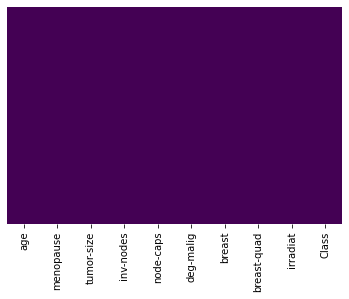

In [117]:
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
df.isnull().sum()

In [118]:
len(df)-len(df.drop_duplicates())

905913

no-recurrence-events    702823
recurrence-events       297177
Name: Class, dtype: int64

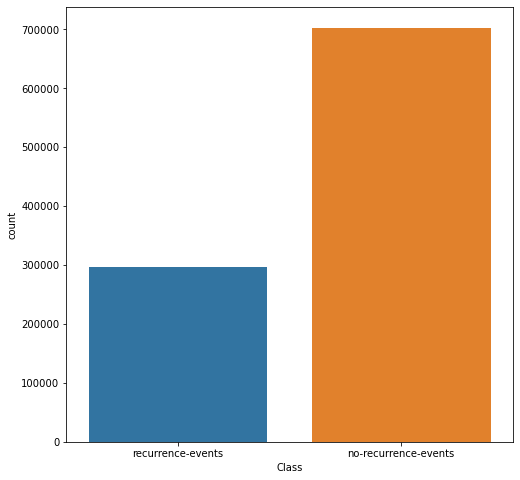

In [119]:
fig = plt.subplots(figsize=(8,8))
sns.countplot(x=df['Class'])
df['Class'].value_counts()

In [120]:
df.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

In [121]:
Categorical_features = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps','breast', 'breast-quad', 'irradiat']
Numerical_features = ['deg-malig']
target = ['Class']

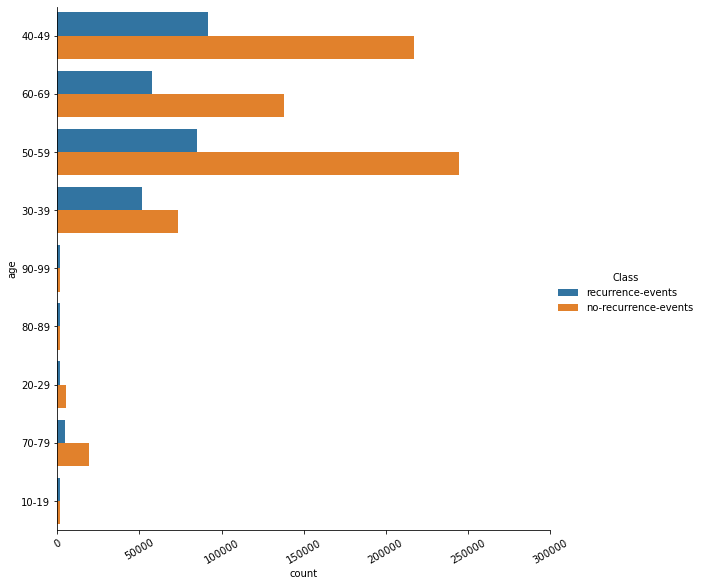

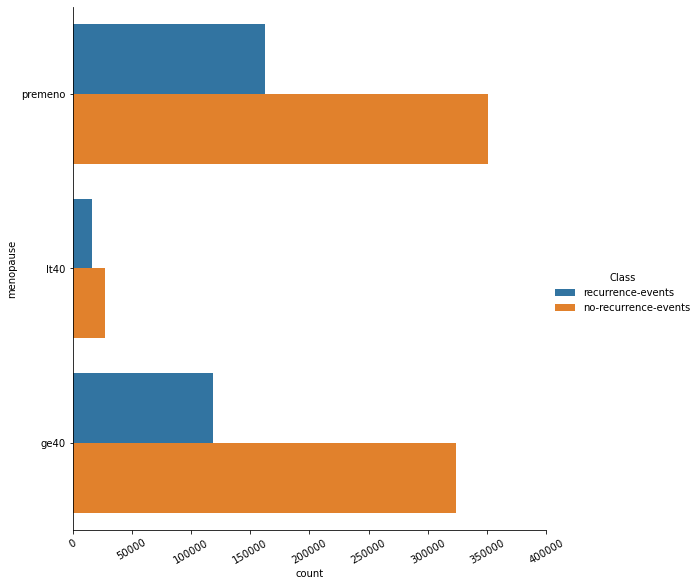

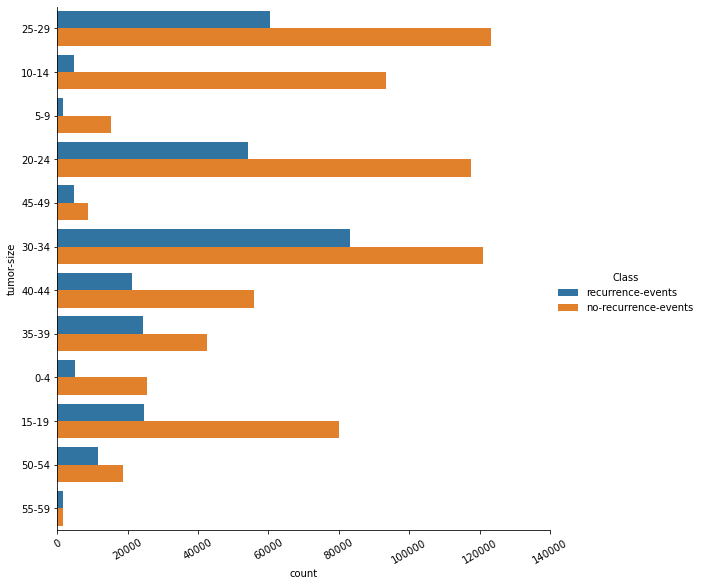

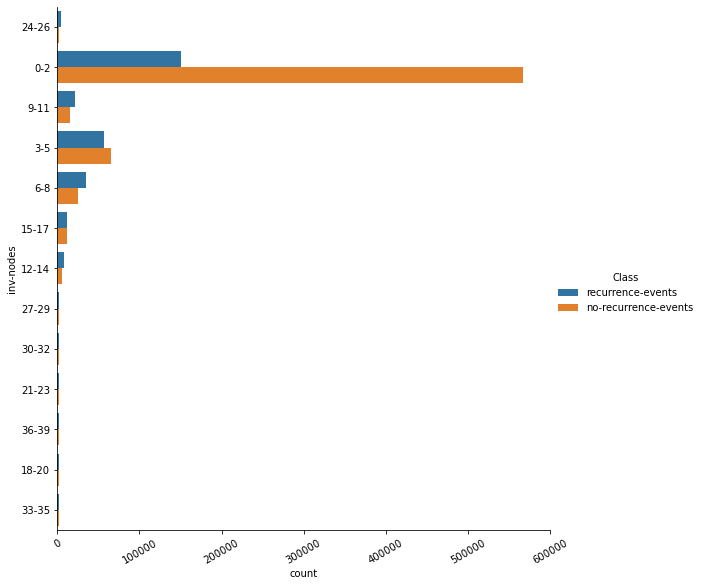

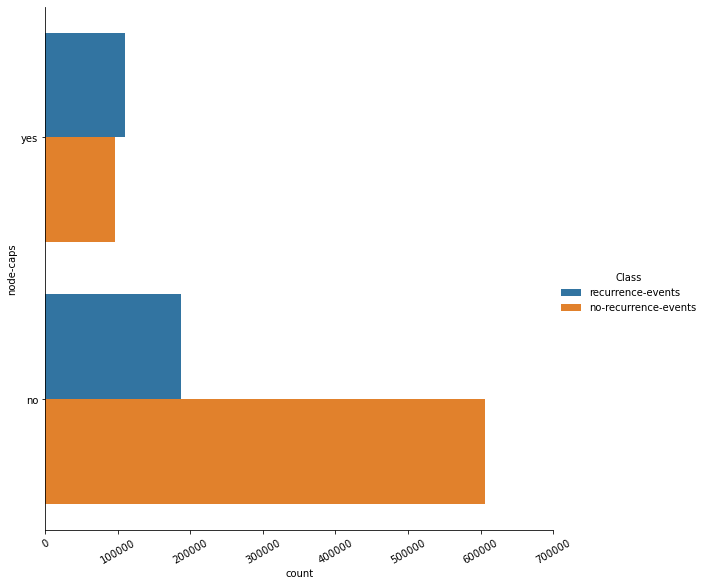

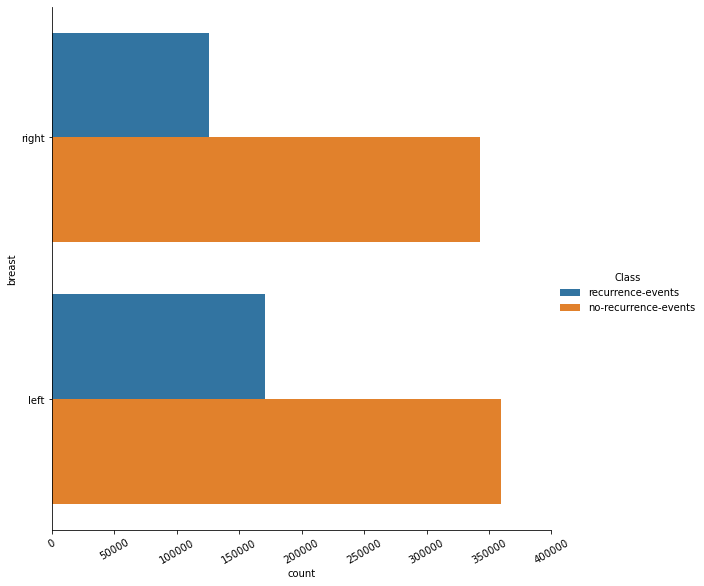

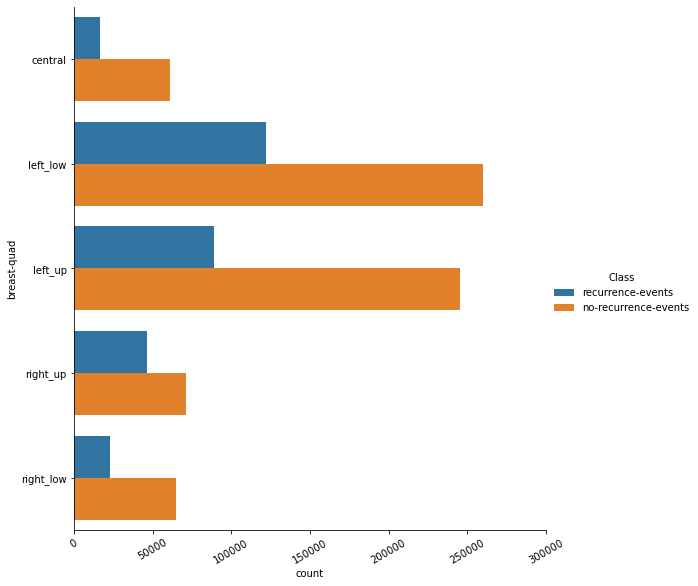

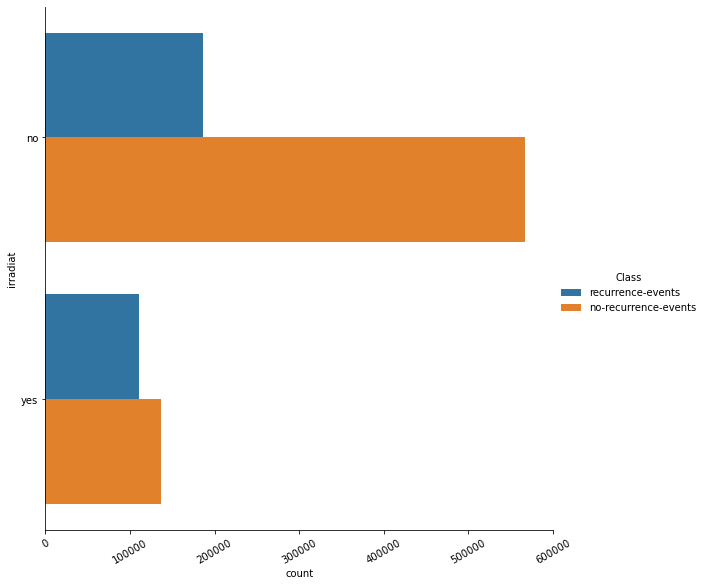

In [122]:
for col in Categorical_features:
    fig = sns.catplot(data=df, y=col, hue='Class', kind='count', orient='V', height=8)
    fig.set_xticklabels(rotation=30)
    plt.show()

<Figure size 1296x720 with 0 Axes>

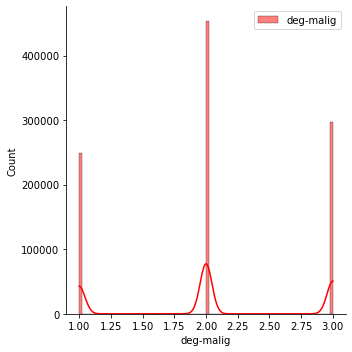

In [123]:
for col in Numerical_features:
    plt.figure(figsize=(18,10))
    sns.displot(df[col], color='red', label=col, kde=True)
    plt.legend()

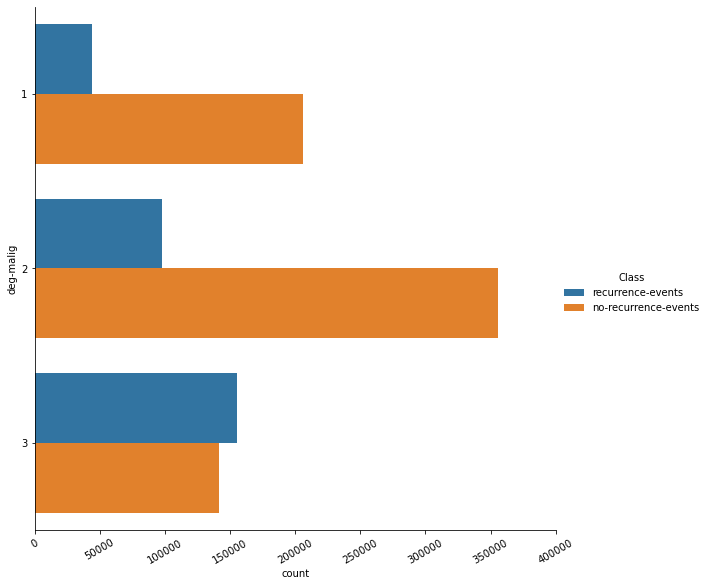

In [124]:
fig = sns.catplot(data=df, y='deg-malig', hue='Class', kind='count', orient='V', height=8)
fig.set_xticklabels(rotation=30)
plt.show()

In [125]:
Categorical_features = ['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps','breast', 'breast-quad', 'irradiat','Class']
for x in Categorical_features:
    df[x] = LabelEncoder().fit_transform(df[x])

In [126]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,3,2,4,5,1,3,1,0,0,1
1,3,2,4,0,0,2,0,1,0,0
2,5,1,4,0,0,2,1,1,0,0
3,3,0,1,0,0,3,0,1,0,0
4,3,2,9,0,0,1,1,0,0,0


In [127]:
df.describe()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,3.674895,1.070332,4.113922,2.179725,0.206122,2.046974,0.469200,1.787228,0.247554,0.297177
std,1.092079,0.975427,2.233561,3.877630,0.404519,0.737740,0.499051,1.098555,0.431591,0.457015
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000
50%,4.000000,2.000000,4.000000,0.000000,0.000000,2.000000,0.000000,2.000000,0.000000,0.000000
75%,4.000000,2.000000,5.000000,2.000000,0.000000,3.000000,1.000000,2.000000,0.000000,1.000000
max,8.000000,2.000000,11.000000,12.000000,1.000000,3.000000,1.000000,4.000000,1.000000,1.000000


In [128]:
df.corr()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
age,1.000000,-0.620075,-0.007442,-0.018245,-0.017067,-0.016893,0.002483,-0.002215,-0.013629,-0.060091
menopause,-0.620075,1.000000,0.006553,0.015832,0.015226,0.014009,-0.002750,0.000997,0.011186,0.050246
tumor-size,-0.007442,0.006553,1.000000,0.036830,0.034664,0.037576,-0.008544,0.004872,0.024006,0.129071
inv-nodes,-0.018245,0.015832,0.036830,1.000000,0.579048,0.209612,-0.017017,0.014317,0.357037,0.283772
node-caps,-0.017067,0.015226,0.034664,0.579048,1.000000,0.313255,-0.016379,0.013004,0.295931,0.261794
deg-malig,-0.016893,0.014009,0.037576,0.209612,0.313255,1.000000,-0.017031,0.013650,0.114991,0.288181
breast,0.002483,-0.002750,-0.008544,-0.017017,-0.016379,-0.017031,1.000000,0.200861,-0.011957,-0.057931
breast-quad,-0.002215,0.000997,0.004872,0.014317,0.013004,0.013650,0.200861,1.000000,0.009383,0.048598
irradiat,-0.013629,0.011186,0.024006,0.357037,0.295931,0.114991,-0.011957,0.009383,1.000000,0.190184
Class,-0.060091,0.050246,0.129071,0.283772,0.261794,0.288181,-0.057931,0.048598,0.190184,1.000000


<AxesSubplot:>

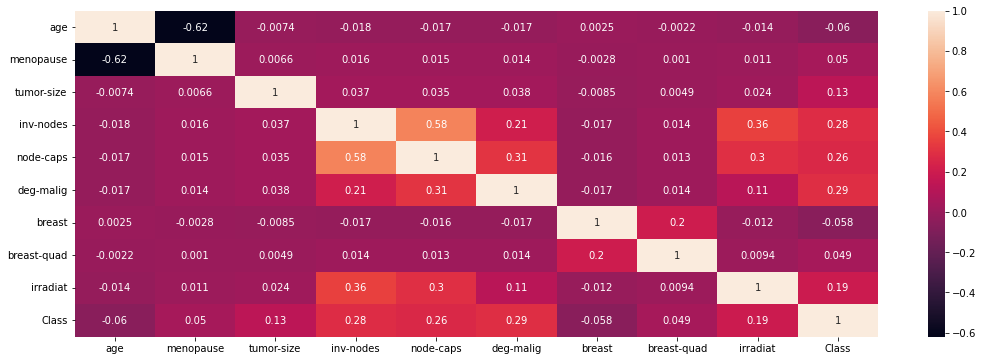

In [129]:
fig = plt.subplots(figsize=(18,6))
sns.heatmap(df.corr(),annot=True)

In [130]:
df.columns

Index(['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat', 'Class'],
      dtype='object')

In [131]:
y = df['Class']
y.head()

0    1
1    0
2    0
3    0
4    0
Name: Class, dtype: int32

In [132]:
X = df[['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'deg-malig',
       'breast', 'breast-quad', 'irradiat']]
X.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,3,2,4,5,1,3,1,0,0
1,3,2,4,0,0,2,0,1,0
2,5,1,4,0,0,2,1,1,0
3,3,0,1,0,0,3,0,1,0
4,3,2,9,0,0,1,1,0,0


In [133]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
print(X)

[[-0.61799121  0.95308845 -0.05100468 ...  1.0636199  -1.62689055
  -0.57358437]
 [-0.61799121  0.95308845 -0.05100468 ... -0.94018549 -0.71660347
  -0.57358437]
 [ 1.21337874 -0.07210382 -0.05100468 ...  1.0636199  -0.71660347
  -0.57358437]
 ...
 [-0.61799121  0.95308845 -0.05100468 ... -0.94018549  0.1936836
   1.74342269]
 [ 0.29769377 -1.09729609 -0.49872045 ...  1.0636199  -0.71660347
   1.74342269]
 [-1.53367619  0.95308845 -1.84186778 ... -0.94018549  0.1936836
  -0.57358437]]


In [134]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
    )

<AxesSubplot:xlabel='Class', ylabel='count'>

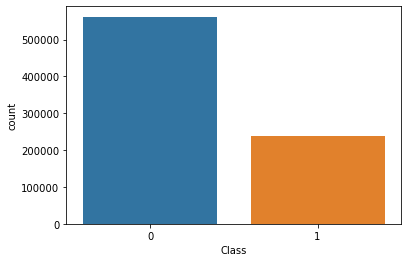

In [135]:
sns.countplot(x=y_train)

In [136]:
borderlineSMOTE = BorderlineSMOTE(k_neighbors= 25, random_state=0)
X_train, y_train = borderlineSMOTE.fit_resample(X_train,y_train)

<AxesSubplot:xlabel='Class', ylabel='count'>

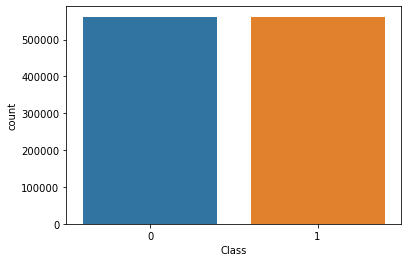

In [137]:
sns.countplot(x=y_train)

In [138]:
# Logistic Regression
class CustomLogisticRegression() :
    def __init__( self, learning_rate, iterations ) :        
        self.learning_rate = learning_rate        
        self.iterations = iterations
          
    # Function for model training    
    def fit( self, X, Y ) :        
        # no_of_training_examples, no_of_features        
        self.m, self.n = X.shape        
        # weight initialization        
        self.W = np.zeros( self.n )        
        self.b = 0        
        self.X = X        
        self.Y = Y
          
        # gradient descent learning
                  
        for i in range( self.iterations ) :            
            self.update_weights()            
        return self
      
    # Helper function to update weights in gradient descent
      
    def update_weights( self ) :           
        A = 1 / ( 1 + np.exp( - ( self.X.dot( self.W ) + self.b ) ) )
          
        # calculate gradients        
        tmp = ( A - self.Y.T )        
        tmp = np.reshape( tmp, self.m )        
        dW = np.dot( self.X.T, tmp ) / self.m         
        db = np.sum( tmp ) / self.m 
          
        # update weights    
        self.W = self.W - self.learning_rate * dW    
        self.b = self.b - self.learning_rate * db
          
        return self
      
    # Hypothetical function  h( x ) 
      
    def predict( self, X ) :    
        Z = 1 / ( 1 + np.exp( - ( X.dot( self.W ) + self.b ) ) )        
        Y = np.where( Z > 0.5, 1, 0 )        
        return Y

----------------------------------------------------------------
The Accuracy of the model is :  67.084 %
----------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.84      0.65      0.74    140572
           1       0.46      0.71      0.56     59428

    accuracy                           0.67    200000
   macro avg       0.65      0.68      0.65    200000
weighted avg       0.73      0.67      0.68    200000



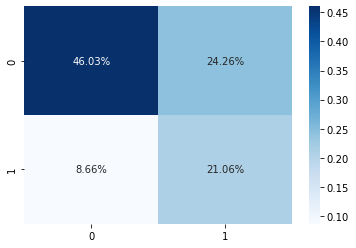

In [139]:
logReg = CustomLogisticRegression(learning_rate = 0.01, iterations = 1000)
logReg.fit(X_train, y_train)

prediction = logReg.predict(X_test)

# Getting and printing model scores
cm = confusion_matrix(y_test,prediction)
sns.heatmap(cm/np.sum(cm), annot= True, fmt='.2%', cmap='Blues')
display(HTML("<h1>Logistic Regression</h1>"))
print('----------------------------------------------------------------')

print("The Accuracy of the model is : ", accuracy_score(y_test, prediction)*100, "%")
print('----------------------------------------------------------------')

# Look at classification report to evaluate the model
print(classification_report(y_test,prediction))

In [140]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='newton-cg', max_iter=150)
model.fit(X_train, y_train)
pred2 = model.predict(X_test)
accuracy2 = accuracy_score(y_test, pred2)
print(accuracy2)

0.66914


c:\Users\Dylan\anaconda3\lib\site-packages\scipy\optimize\linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\Users\Dylan\anaconda3\lib\site-packages\sklearn\utils\optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [142]:
from sklearn.ensemble import RandomForestClassifier
# creating a RF classifier
clf = RandomForestClassifier(n_estimators = 75) 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred = clf.predict(X_test)

accuracy3 = accuracy_score(y_test, y_pred)
print(accuracy3)

0.71522
